In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
from datetime import date
import operator 
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy import integrate, optimize
#from covidmx import CovidMX
plt.style.use('fivethirtyeight')
%matplotlib inline 

In [2]:
DatosMexico=pd.read_csv('C:\\Users\\shada\\Documents\\Covid\\datosmexico.csv',index_col=0)
DatosMichoacan=pd.read_csv('C:\\Users\\shada\\Documents\\Covid\\datosmichoacan.csv',index_col=0)

In [3]:
##MOdelos
def exponential_model(x,a,b):
    return (a/b)*(np.exp(x*b)-1)

def gompertz_model(x,g):
    return k*np.exp(-n0*np.exp(-g*x))

def gompertz_hubbert(x,g):
    return g*n0*np.exp(-g*x)*k*np.exp(-n0*np.exp(-g*x))

def logistic_model(x,r,C0,K):
    return K/(1+((K-C0)/C0)*np.exp(-r*x))

def hubbert_curve(x,r,C0,K):
    return (np.exp(r*x)*r*C0*(K-C0))/(K*(1+C0/K *(np.exp(r*x) -1))**2)
def verhulst_model(y,x,r,K):
    dNdt=r*N*(1-N/K)
    return dNdt
def fit_log(x,r,K):
    return integrate.odeint(verhulst_model,N0,x,args=(r,K))[:,0]

In [4]:
def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec
def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]
def fit_odeint1(x, beta, gamma):
    return integrate.odeint(sir_model, (sus01, inf01, rec01), x, args=(beta, gamma))[:,1]

In [5]:
def SIQR_COVID(y,t,beta,alpha,eta):
    S, I, Q, R = y
    dSdt = -beta*S*I/N 
    dIdt = beta*S*I/N - (alpha+ eta)*I
    dQdt = eta*I - gamma*Q
    dRdt = gamma*Q+alpha*I
    return dSdt, dIdt, dQdt, dRdt
def fit_odeint_1(x,beta,alpha,eta):
    return integrate.odeint(SIQR_COVID,(S0,I0,Q0,R0),x,args=(beta,alpha,eta))[:,1]
def fit_odeint1_1(x,beta,alpha,eta):
    return integrate.odeint(SIQR_COVID,(S01,I01,Q01,R01),x,args=(beta,alpha,eta))[:,1]

In [6]:
#MODELOS SIR
def data_real(df,final):
    df=df[:final]
    y2 = list(df.loc[:,'Nuevos'])
    y1 = list(df.loc[:,'Activos'])
    fecha=df.index[0]
    x= list(range(0,len(y2)))
    return x,y1,y2
def data_inicial(df,final):
    df=df[:final]
    y2 = list(df.loc[:,'Nuevos'])
    y1 = list(df.loc[:,'Activos'])
    yt=list(df.loc[:,'Recuperados'])
    rec0=yt[0]
    fecha=df.index[0]
    x= list(range(0,len(y2)))
    inf0=y1[0]
    return inf0, rec0
def data_inicial_s(df,final):
    df=df[:final]
    y2 = list(df.loc[:,'Nuevos'])
    y1 = list(df.loc[:,'Activos'])
    yt=list(df.loc[:,'Recuperados'])
    rec0=yt[0]
    fecha=df.index[0]
    x= list(range(0,len(y2)))
    inf0=y1[0]
    return inf0, rec0,x,y1
def data_real2(df,inicio,final):
    dft=df[inicio:final]
    yt=list(dft.loc[:,'Activos'])
    rec0=yt[0]
    df=df[inicio:final]
    y2 = list(df.loc[:,'Nuevos'])
    y1 = list(df.loc[:,'Activos'])
    fecha=df.index[0]
    x= list(range(0,len(y2)))
    
    return x,y1,y2,rec0
def data_inicial2(df,inicio,final):
    dft=df[inicio:final]
    yt=list(dft.loc[:,'Activos'])
    rec0=yt[0]
    df=df[inicio:final]
    y2 = list(df.loc[:,'Nuevos'])
    y1 = list(df.loc[:,'Activos'])
    fecha=df.index[0]
    x= list(range(0,len(y2)))
    inf0=y1[0]
    return inf0,rec0
def data_inicial2_s(df,inicio,final):
    dft=df[inicio:final]
    yt=list(dft.loc[:,'Activos'])
    rec0=yt[0]
    df=df[inicio:final]
    y2 = list(df.loc[:,'Nuevos'])
    y1 = list(df.loc[:,'Activos'])
    fecha=df.index[0]
    x= list(range(0,len(y2)))
    inf0=y1[0]
    return x,y1

In [7]:
def parametros_SIQR1(df,final,poblacion):
    ##
    ##
    
    df=df[:final]
    y2 = list(df.loc[:,'Nuevos'])
    y1 = list(df.loc[:,'Activos'])
    fecha=df.index[0]
    x= list(range(0,len(y2)))
    #condiciones iniciales
    N=poblacion
    inf0 = y1[0]
    sus0 = N-inf0
    rec0 = 0.0
    #fit parametros
    
    popt, pcov = optimize.curve_fit(fit_odeint1, x, y1)
    
    time1 = pd.date_range(start=fecha, periods=len(y1))
    time2= pd.date_range(start=fecha, periods=401)  
    hoy=len(y1)
    t = np.linspace(1, len(y1),len(y1))
    
    fitted = fit_odeint1(x, *popt)
##plot temporal
    plt.plot(x, y1, 'o')
    plt.plot(x, fitted)
    plt.title("Fit of SIR model for Michoacan infected cases")
    plt.ylabel("Population infected")
    plt.xlabel("Days")
    plt.show()
    print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
    
    return df, popt, pcov, t,time1 ,y1,y2
    #return
def parametros_SIQR1_s(df,final,poblacion):
    df=df[:final]
    y2 = list(df.loc[:,'Nuevos'])
    y1 = list(df.loc[:,'Activos'])
    fecha=df.index[0]
    x1=list(range(0,len(y2)))
    #condiciones iniciales
    N=poblacion
    I0 = y1[0]
    S0 = N-I0
    R0 = 0.0
    Q0=0.0
    
    #fit parametros
    
    popt, pcov = optimize.curve_fit(fit_odeint1_1, x1, y1)
    
    time1 = pd.date_range(start=fecha, periods=len(y1))
    time2= pd.date_range(start=fecha, periods=401)   
    hoy=len(y1)
    t = np.linspace(1, len(y1),len(y1))
    
    fitted = fit_odeint1_1(x1, *popt)
##plot temporal
    plt.plot(x1, y1, 'o')
    plt.plot(x1, fitted)
    plt.title("Fit of SIQR model for Michoacan infected cases")
    plt.ylabel("Population infected")
    plt.xlabel("Days")
    plt.show()
    print("Optimal parameters: beta =", popt[0], "  alpha = ", popt[1], "eta = ", popt[2])
    
    return df, popt, pcov, t,time1 ,y1,y2
    #return

In [8]:
def parametros_SIQR2_s(df,inicio,final,poblacion):
    df=df[inicio:final]
    yt=list(df.loc[:,'Recuperados'])
    y2 = list(df.loc[:,'Nuevos'])
    y1 = list(df.loc[:,'Activos'])
    fecha=df.index[0]
    x2= list(range(0,len(y1)))
     
    
#     N=poblacion
#     I0 = y1[0]
#     S0 = N-I0
#     R0 = yt[0]
#     Q0=0.0
    
    #fit parametros
    
    popt, pcov = optimize.curve_fit(fit_odeint_1, x2, y1)
    
    time1 = pd.date_range(start=fecha, periods=len(y1))
    time2= pd.date_range(start=fecha, periods=401)   
    hoy=len(y1)
    t = np.linspace(1, len(y1),len(y1))
    
    fitted = fit_odeint_1(x2, *popt)
##plot temporal
    plt.plot(x2, y1, 'o')
    plt.plot(x2, fitted)
    plt.title("Fit of SIQR model for Michoacan infected cases")
    plt.ylabel("Population infected")
    plt.xlabel("Days")
    plt.show()
    print("Optimal parameters: beta =", popt[0], "  alpha = ", popt[1], "eta = ", popt[2])
    
    return df, popt, pcov, t,time1,y1,y2
    #return

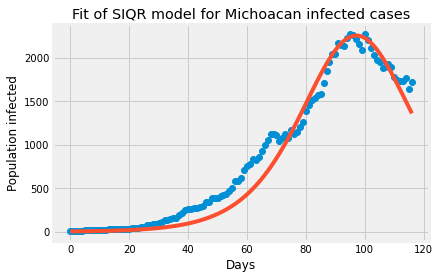

Optimal parameters: beta = 2.3842988085386647   alpha =  1.2914625135774023 eta =  1.0132244563203374


In [9]:
N=4000000
gamma=0.036

#I01, R01,x,y1 =data_inicial_s(DatosMichoacan,'2020-07-15')
I01=4
S01 = N -I01
Q01=0.0
R01=0.0

#popt, pcov = optimize.curve_fit(fit_odeint1_1, x, y1)
A=parametros_SIQR1_s(DatosMichoacan,'2020-07-15',4000000)


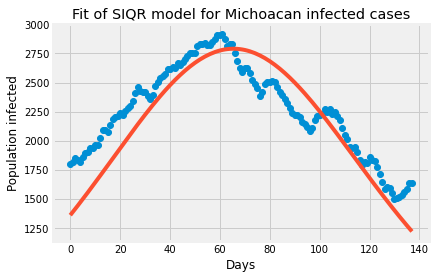

Optimal parameters: beta = 0.7622067161760694   alpha =  0.7139003424837311 eta =  -0.012614994329483237


In [10]:
beta1,alpha1, eta1=A[1]
Rb1=beta1/(alpha1+eta1)
S0,I0,Q0,R0=4000000,4,0,0
ret1=integrate.odeint(SIQR_COVID,(S0,I0,Q0,R0),A[3],args=(beta1,alpha1,eta1))
S1,I1,Q1,R1=ret1.T
S0,I0,Q0,R0=S1[-1],I1[-1],Q1[-1],R1[-1]
#x,y1=data_inicial2_s(DatosMichoacan,'2020-07-16','2020-11-30')

B=parametros_SIQR2_s(DatosMichoacan,'2020-07-16','2020-11-30',4000000)

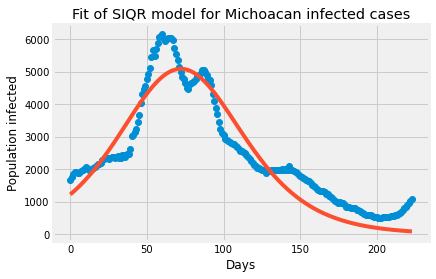

Optimal parameters: beta = 0.789587330306053   alpha =  0.15621140110870518 eta =  0.5166908880199169


In [12]:
beta2,alpha2, eta2=B[1]
Rb2=beta2/(alpha2+eta2)
S0,I0,Q0,R0=S1[-1],I1[-1],Q1[-1],R1[-1]
ret2=integrate.odeint(SIQR_COVID,(S0,I0,Q0,R0),B[3],args=(beta2,alpha2,eta2))
S2,I2,Q2,R2=ret2.T
S0,I0,Q0,R0=S2[-1],I2[-1],Q2[-1],R2[-1]
#x,y1=data_inicial2_s(DatosMichoacan,'2020-12-1','2021-06-18')

C=parametros_SIQR2_s(DatosMichoacan,'2020-12-01','2021-07-12',4000000)

In [13]:
beta3,alpha3, eta3=C[1]
Rb3=beta3/(alpha3+eta3)
S0,I0,Q0,R0=S2[-1],I2[-1],Q2[-1],R2[-1]
ret3=integrate.odeint(SIQR_COVID,(S0,I0,Q0,R0),C[3],args=(beta3,alpha3,eta3))
S3,I3,Q3,R3=ret3.T


In [14]:
#R_0 respectivos
Rb1,Rb2, Rb3=round(Rb1,3),round(Rb2,3), round(Rb3,3)

In [15]:
def plot_SIQR_2(df,country,A,B,C):

    #NUevo
#     inf0, rec0 =data_inicial(df,'2020-07-15')
#     sus0 = poblacion - inf0
#     df1, par_log1,cov_log1,t1,time1,y_acum1,y_nue1 =parametros_SIQR1(df,'2020-07-15',poblacion)
#     inf0, rec0 =data_inicial2(df,'2020-07-16','2020-11-30')
#     sus0 = poblacion - inf0
#     df2, par_log2,cov_log2,t2,time2,y_acum2,y_nue2 =parametros_SIQR2(df,'2020-07-16','2020-11-30',poblacion)
#     inf0, rec0 =data_inicial2(df,'2020-12-1','2021-06-15')
#     sus0 = poblacion - inf0
#     df3, par_log3,cov_log3,t3,time3,y_acum3,y_nue3=parametros_SIQR2(df,'2020-12-1',final,poblacion)

#CARGAR DATOS
    df1,par_log1,cov_log1,t1,time1,y_acum1,y_nue1 = A
    df2,par_log2,cov_log2,t2,time2,y_acum2,y_nue2=B
    df3,par_log3,cov_log3,t3,time3,y_acum3,y_nue3=C

#Preddicion


    hoy=time3[-1] + datetime.timedelta(days=1)
    time_p = pd.date_range(start=hoy, periods=15)
    t_p = np.linspace(t3[-1], t3[-1]+15,15)    
##



   ###Grafica1 

    plt.figure(figsize=(16, 9))
    #plt.plot(time1, fit_odeint1_1(t1,par_log1[0],par_log1[1],par_log1[2]),color='black',label='Modelo SIQR 1')
    plt.plot(time1, I1,color='black',label='Modelo SIQR')
     #
    plt.plot(time2, I2,color='black')
    #plt.plot(time2, fit_odeint_1(t2,par_log2[0],par_log2[1],par_log2[2]),color='black',label='Modelo SIQR 2')
     #
    plt.plot(time3, I3,color='black')
    #plt.plot(time3, fit_odeint_1(t3,par_log3[0],par_log3[1],par_log3[2]),color='black',label='Modelo SIQR 3')
    
    #predicion
    
    #plt.plot(time_p, fit_odeint(t_p,par_log3[0],par_log3[1]),color='black',label='Modelo SIR 1')
    #prediccion hoy
    #plt.scatter(hoy, fit_odeint(t_p[0],par_log3[0],par_log3[1]),color='black',s=120)
    #
    plt.bar(time1, y_acum1,label='Casos activos período 1')
    plt.bar(time2, y_acum2,label='Casos activos período 2')
    plt.bar(time3, y_acum3,label='Casos activos período 3')
    #plt.text(time1[60],max(I3),'$R^2={}$'.format(r_square),{'color': 'black', 'fontsize': 40})
    plt.text(time1[int(len(time1)/2)],1000,'$R_0={}$'.format(Rb1),{'color': 'black', 'fontsize': 20})
    plt.text(time2[int(len(time2)/2)],1000,'$R_0={}$'.format(Rb2),{'color': 'black', 'fontsize': 20})
    plt.text(time3[int(len(time3)/2)],1000,'$R_0={}$'.format(Rb3),{'color': 'black', 'fontsize': 20})
    plt.title('Casos activos en {}'.format(country), size=30)
    plt.xlabel('Días desde {}'.format(time1[0].strftime('%d-%m-%Y')), size=30)
    plt.ylabel('# de Casos', size=30)
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().set_xlim(time1[0], time3[-1]+datetime.timedelta(days=8))
    #plt.gca().set_ylim(0, y_acum3[-1]+10000)
    plt.xticks(size=20)
    #plt.xticks(rotation=45)
    plt.yticks(size=20)   
    legend = plt.legend()
    plt.savefig("E:\\Graficas\\SIQRetapas{}-1.pdf".format(country), dpi=300, bbox_inches='tight')
    plt.show()
    return 

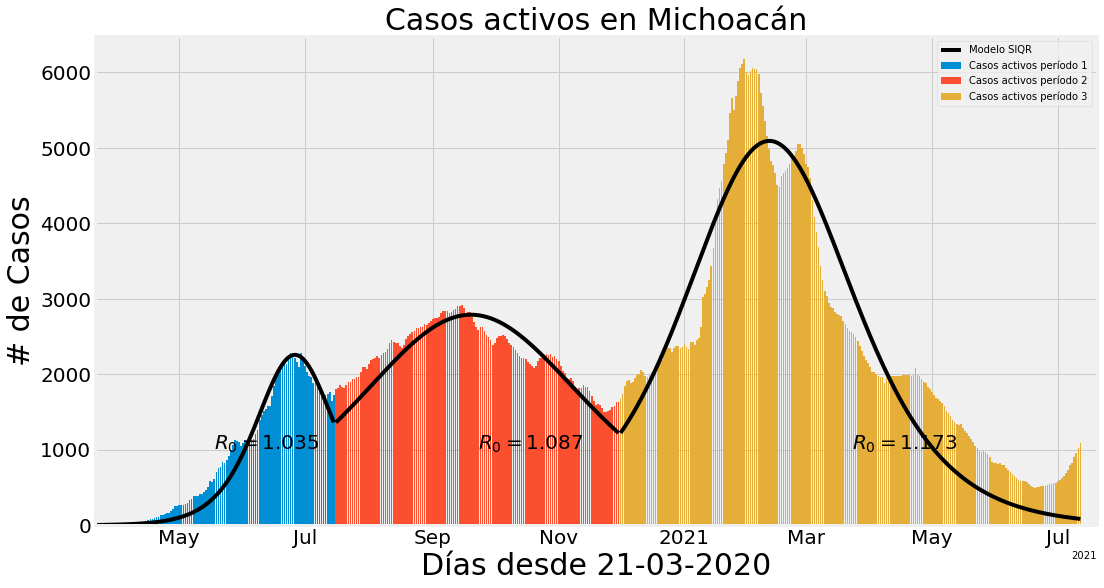

In [16]:
plot_SIQR_2(DatosMichoacan,'Michoacán',A,B,C)